In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.8 MB/s eta 0:00:00


In [3]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/VPB.csv')
df = df[['Price','Low']]

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validating sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

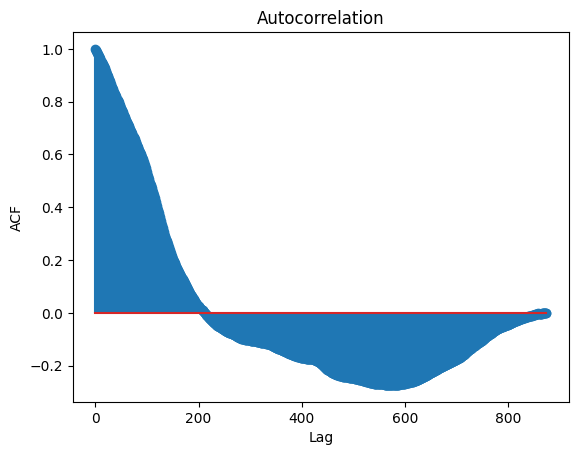

In [14]:
# 3. Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 1500)

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation')
plt.show()

In [5]:
# 4. Quá trình training
y_train = np.array(train_data['Price'])

x_train = []
for data in train_data['Low']:
  x_train.append([data])

model = dlm(y_train)
model = model + trend(1, discount=0.99, name='Trend', w=1e7)
model = model + dynamic(features=x_train, discount=1, name='Low')
model = model + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model = model + longSeason(period=12, stay=30, data=y_train, name='season', w=1e7)


model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [6]:
# 5. Quá trình testing
x_test= []
for data in test_data['Low']:
  x_test.append([data])

y_test = np.array(test_data['Price'])

y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'Low': x_test})
y_pred = y_pred[0]


In [7]:
# 6. Quá trình Validate
x_val= []
for data in val_data['Low']:
  x_val.append([data])

y_val = np.array(val_data['Price'])

y_pred_val = model.predictN(featureDict={'Low': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]


In [8]:
# 7. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 3817.044792736491
Testing RMSE: 3898.9443866885463
Validation MAPE: 20.27819028699983
Testing MAPE: 18.055614267212867
Validation MAE: 3788.1495905379993
Testing MAE: 3420.636944002576


In [9]:
#  8. Sử dụng linear regression dự báo cột Low 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])


# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
low_next_30_days = ln_model.predict(index_next_30_days)

print(low_next_30_days)


[25697.32113553 25714.81087451 25732.3006135  25749.79035249
 25767.28009148 25784.76983046 25802.25956945 25819.74930844
 25837.23904742 25854.72878641 25872.2185254  25889.70826439
 25907.19800337 25924.68774236 25942.17748135 25959.66722033
 25977.15695932 25994.64669831 26012.1364373  26029.62617628
 26047.11591527 26064.60565426 26082.09539324 26099.58513223
 26117.07487122 26134.56461021 26152.05434919 26169.54408818
 26187.03382717 26204.52356615]


In [10]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days = []
for data in low_next_30_days:
  x_next_30_days.append([data])

y_next_30_days = model.predictN(N = 30, featureDict={'Low': x_next_30_days})
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


[26162.425276062226, 26262.47684627604, 26266.752308859865, 26300.040663775675, 26316.803133332214, 26340.31894240585, 26360.58868468552, 26382.294757910848, 26403.338428632407, 26424.68126487167, 26445.887559936727, 26467.15584429455, 26488.39591062052, 26509.64880480395, 26530.8958635309, 26552.14557593367, 26573.394081369857, 26594.64313572116, 26615.89194042108, 26637.140858662144, 26658.389725264267, 26679.638615351843, 26700.887494758175, 26722.136379022362, 26743.385261077183, 26623.704471583635, 26677.309469361713, 26676.57321651339, 26706.156441985277, 26723.233705382656]


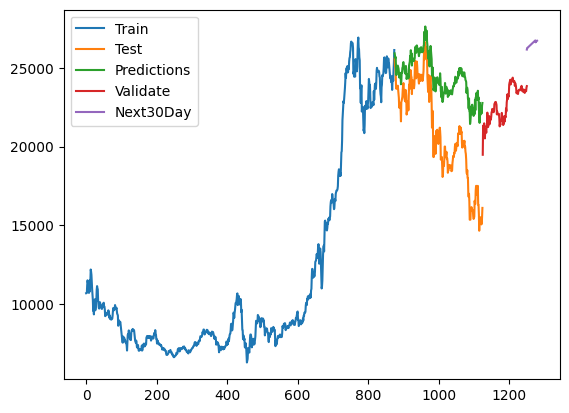

In [11]:
# 10. Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()